In [44]:
import numpy as np
import matplotlib.pyplot as plt

from astropy.io import fits
import astropy.units as u
from astropy.units import cds

c = cds.c

## Get the antenna positions

In [36]:
hdul = fits.open("1164110416.metafits")
N = hdul[1].data["north"][::2] * u.m
E = hdul[1].data["east"][::2] * u.m
hdul.close()

nant = len(N)

## Construct a horizon (RFI) function

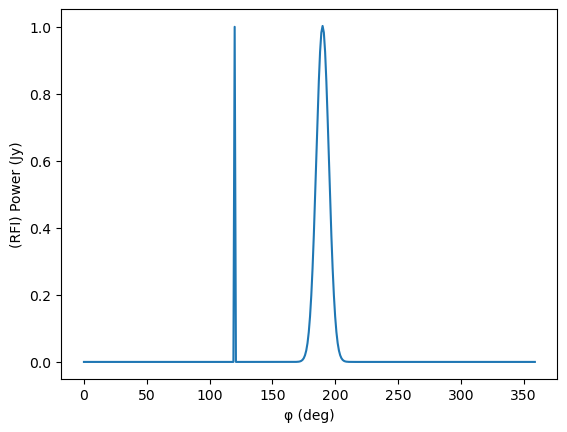

In [62]:
# Let φ be the compass bearing (angle from North towards East)
φ = np.linspace(0, 360, num=360, endpoint=False) * u.degree
dφ = 360/len(φ) * u.degree

# A point-like RFI source at about bearing 120°
RFI_1 = np.zeros(φ.shape) * u.Jy
RFI_1[len(φ)//3] = 1 * u.Jy

# A diffuse, Gaussian source centred at 190°
σ = 5 * u.degree
μ = 190 * u.degree
A = 2 * u.Jy
RFI_2 = A * (dφ / σ*np.sqrt(2*np.pi)) * np.exp(-0.5*(φ - μ)**2 / σ**2)

# Total RFI
RFI = RFI_1 + RFI_2

plt.plot(φ, RFI)
plt.xlabel(f"φ ({φ.unit})")
plt.ylabel(f"(RFI) Power ({RFI.unit})")

# Let the RFI be at some particular frequency
ν = 150 * u.MHz
λ = c/ν

This function is what we're going to try and recover.

## Simulate the visibilities for each baseline

In [63]:
# The baseline vectors expressed in terms of number of wavelengths
# The coordinate system is (p,q), where p-hat is north and q-hat is east
Dλvec = [[((N[j] - N[i])/λ).decompose(),
          ((E[j] - E[i])/λ).decompose()] for i in range(nant-1) for j in range(i+1, nant)]

In [64]:
# The direction cosines
φvec = [[np.cos(φi), np.sin(φi)] for φi in φ]

In [65]:
# The twiddle factors
tw = np.array([[np.exp(-1j*2*np.pi*np.dot(Dλ, φvec[i])) for i in range(len(φ))] for Dλ in Dλvec])
# The interferometer measurement equation
#Vs = [np.sum(RFI[i] * np.exp(-1j*2*np.pi*np.dot(Dλ, φ[i])))]

In [72]:
# Construct the visibilities
V = tw @ RFI

## Test least squares inversion

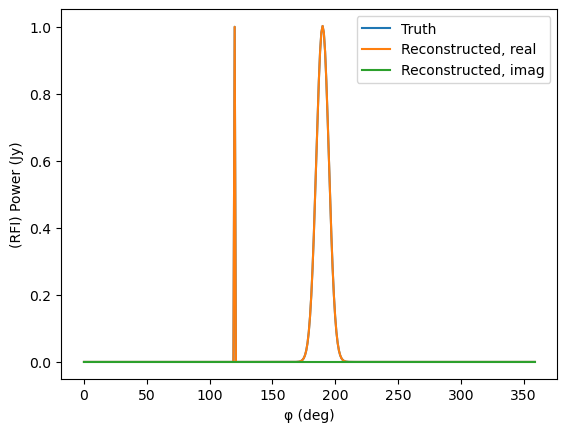

In [81]:
RFIhat = np.linalg.pinv(tw.T @ tw) @ tw.T @ V
plt.plot(φ, RFI, label="Truth")
plt.plot(φ, np.real(RFIhat), label="Reconstructed, real")
plt.plot(φ, np.imag(RFIhat), label="Reconstructed, imag")
plt.xlabel(f"φ ({φ.unit})")
plt.ylabel(f"(RFI) Power ({RFI.unit})")
plt.legend()

Text(0.5, 1.0, 'Difference between real part of reconstructed and the truth')

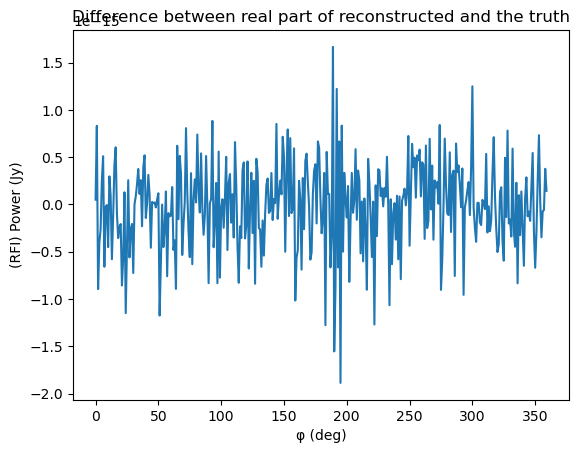

In [82]:
# Difference between real part and truth
plt.plot(φ, np.real(RFIhat) - RFI)
plt.xlabel(f"φ ({φ.unit})")
plt.ylabel(f"(RFI) Power ({RFI.unit})")
plt.title("Difference between real part of reconstructed and the truth")